In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os
from astropy import coordinates as coords
import astropy.units as u
from pathlib import Path
from PIL import Image
from astropy.coordinates import SkyCoord
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In the cell below this was how I converted the ra and dec of Galaxy Zoo 1's dataset. It also contains how I converted the EFIGI txt files to csv files for manipulation of the data

In [89]:
df_gz = pd.read_csv('GalaxyZoo1_DR_table2.csv')
df_gz_converted = pd.read_csv('GalaxyZoo1_DR_table2.csv')

# sk = SkyCoord(ra=df_gz['RA'], dec=df_gz['DEC'],unit=(u.hourangle, u.deg)) #conveting RA and DEC to degrees

# df_gz_converted['RA'] = sk.ra.deg
# df_gz_converted['DEC'] = sk.dec.deg
# df_gz_converted.to_csv('GalaxyZoo1_DR_table2_converted_ra_dec.csv', index=False)

df_efigi_coords = pd.read_csv("efigi-1.6\EFIGI_coord_redshift.txt", 
                 delim_whitespace=True, 
                 comment="#")
#df_efigi_coords.to_csv("EFIGI_coord_redshift.csv", index=False)

df_efigi_types = pd.read_csv('efigi-1.6\EFIGI_HyperLeda.txt',
                delim_whitespace=True, 
                comment="#")
#df_efigi_types.to_csv("EFIGI_types.csv", index=False)

df_efigi_objid = pd.read_csv('efigi-1.6\EFIGI_SDSS.txt',
                delim_whitespace=True, 
                comment="#")
#df_efigi_objid.to_csv("EFIGI_objid.csv", index=False)

C:\Users\young\AppData\Local\Temp\ipykernel_27424\610129204.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_efigi_coords = pd.read_csv("efigi-1.6\EFIGI_coord_redshift.txt",
C:\Users\young\AppData\Local\Temp\ipykernel_27424\610129204.py:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_efigi_types = pd.read_csv('efigi-1.6\EFIGI_HyperLeda.txt',
C:\Users\young\AppData\Local\Temp\ipykernel_27424\610129204.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_efigi_objid = pd.read_csv('efigi-1.6\EFIGI_SDSS.txt',


In the cell below I used this cell to create a combined EFIGI csv file that contained all the information about EFIGI_coord_redshift_copy and added the columns objID and type from the other EFIGI files

In [3]:
combined_df = pd.read_csv('efigi-1.6\EFIGI_coord_redshift_copy.csv',delim_whitespace=True, 
                          comment="#")

select_objid = df_efigi_objid['objId']
select_type = df_efigi_types['type']

combined_df['OBJID'] = select_objid
combined_df['type'] = select_type
combined_df.to_csv("EFIGI_combined.csv", index=False)


C:\Users\young\AppData\Local\Temp\ipykernel_27424\3370456394.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  combined_df = pd.read_csv('efigi-1.6\EFIGI_coord_redshift_copy.csv',delim_whitespace=True,


In the cell below I used this cell to combine the EFIGI combined file with Galaxy Zoo 1 with an inner merge. 


In [9]:
combined_data_efigi = pd.read_csv("EFIGI_combined.csv")
gz_data = pd.read_csv("GalaxyZoo1_DR_table2.csv", comment='#')

combined_data_efigi['OBJID'] = combined_data_efigi['OBJID'].astype(str)#convert to string for easier merging because it doesn't work otherwise
gz_data['OBJID'] = gz_data['OBJID'].astype(str)

merged_data = pd.merge(combined_data_efigi, gz_data, on='OBJID', how='inner')#inner merge so I keep only galaxies that are in both catalogs and combine thier data

merged_data.to_csv("EFIGI_GZ_combined.csv", index=False)#after merging, 
#save the combined data you have to go inside the file and remove the quotation marks and change the first ra and dec to lower case

Before moving on you need to look in the EFIGI_GZ_combined.csv and get rid of the "" and change the first RA and DEC into lowercase ra and dec. I used this cell below to pull information that I cared about when trying to filter the images that I needed

In [11]:
df_merged_efigi_gz = pd.read_csv("EFIGI_GZ_combined.csv")

merged_efigi_gz = df_merged_efigi_gz[["PGC_name", 'OBJID','ra', 'dec', 'type', 'SPIRAL', 'ELLIPTICAL', 'UNCERTAIN']]

merged_efigi_gz.to_csv("EFIGI_GZ_merged_data.csv", index=False)

What this cell below does is it iterates over the file ima_r and then if there are matching pgc_ids it then copys them to the folder filter_fits

In [48]:
pgc_list = merged_efigi_gz['PGC_name'].unique()

fits_dir = Path("ima_r")
filtered_dir = Path("filtered_fits")
filtered_dir.mkdir(exist_ok=True)#created the filtered_fits directory if it doesn't exist

for file in fits_dir.glob("*.fits"):#checks for all the fits files in the ima_r
    filename = file.stem #ignores the .fits of the file
    pgc_id = filename.split("_")[0]#this breaks up the file name if there is a _ and takes the first element the pgc_id 
    
    if pgc_id in pgc_list:
        filtered_file = filtered_dir / file.name #this is basically accessing the filtered_fits folder and adding the file name to it
        filtered_file.write_bytes(file.read_bytes()) # copies the files that have matched pgc_id add copys them to the filtered_fits folder
        print("Added " + file.name)

Added PGC0000212_r.fits
Added PGC0000243_r.fits
Added PGC0000281_r.fits
Added PGC0000451_r.fits
Added PGC0000548_r.fits
Added PGC0000635_r.fits
Added PGC0000639_r.fits
Added PGC0000670_r.fits
Added PGC0000963_r.fits
Added PGC0001058_r.fits
Added PGC0001237_r.fits
Added PGC0001293_r.fits
Added PGC0001306_r.fits
Added PGC0001478_r.fits
Added PGC0001523_r.fits
Added PGC0001621_r.fits
Added PGC0001713_r.fits
Added PGC0001747_r.fits
Added PGC0001805_r.fits
Added PGC0001841_r.fits
Added PGC0001862_r.fits
Added PGC0001936_r.fits
Added PGC0002035_r.fits
Added PGC0002076_r.fits
Added PGC0002149_r.fits
Added PGC0002151_r.fits
Added PGC0002182_r.fits
Added PGC0002288_r.fits
Added PGC0002332_r.fits
Added PGC0002388_r.fits
Added PGC0002391_r.fits
Added PGC0002482_r.fits
Added PGC0002501_r.fits
Added PGC0002522_r.fits
Added PGC0002527_r.fits
Added PGC0002600_r.fits
Added PGC0002615_r.fits
Added PGC0002768_r.fits
Added PGC0002800_r.fits
Added PGC0003072_r.fits
Added PGC0003140_r.fits
Added PGC0003314

In the cell below it is iterating over each row in EFIGI_GZ_merged_data.csv and is checking the type and if it begins with S it is a spiral, if it is an E it is a elliptical, and if it begins with an I it is an irregular and anything else is labled uncertain

In [55]:
df_merged_efigi_gz_classification = pd.read_csv("EFIGI_GZ_merged_data.csv")

df_merged_efigi_gz_classification['type'] = df_merged_efigi_gz_classification['type'] 

df_merged_efigi_gz_classification['Classification'] = None #creating a empty new column 

for index, row in df_merged_efigi_gz_classification.iterrows():
    types = df_merged_efigi_gz_classification.at[index, 'type']#this checks each row in the 'type' column and assigns it either Spiral, Elliptical, Irregular or Uncertain based on the first letter of the type
    if types.startswith('S'):
        df_merged_efigi_gz_classification.at[index, 'Classification'] = 'Spiral'
    elif types.startswith('E'):
        df_merged_efigi_gz_classification.at[index, 'Classification'] = 'Elliptical'
    elif types.startswith('I'):
        df_merged_efigi_gz_classification.at[index, 'Classification'] = 'Irregular'
    else:
        df_merged_efigi_gz_classification.at[index, 'Classification'] = 'Uncertain'
        

changes = {"PGC0003620": "Spiral",
    "PGC0012801": "Elliptical",
    "PGC0012803": "Spiral",
    "PGC0013204": "Spiral",
    "PGC0034989": "Irregular",
    "PGC0050251": "Spiral",
    "PGC0054317": "Spiral",
    "PGC0056770": "Elliptical",
    "PGC0058049": None  #Delete
}
for pgc_id, label in changes.items():#iterates through the changes dictionary, where the key is the PGC name and the value is the new label
    if label is not None:
        df_merged_efigi_gz_classification.loc[df_merged_efigi_gz_classification["PGC_name"] == pgc_id, "Classification"] = label# if lable is not None it takes the assigned label given to it from the dictionary
    else:
        df_merged_efigi_gz_classification = df_merged_efigi_gz_classification[df_merged_efigi_gz_classification["PGC_name"] != pgc_id]
        
classified_data = df_merged_efigi_gz_classification[['PGC_name', 'OBJID', 'ra', 'dec', 'type', 'Classification', 'SPIRAL', 'ELLIPTICAL', 'UNCERTAIN']]
classified_data.to_csv("EFIGI_GZ_classified_data.csv", index=False) #2053 Spirals, 230 Ellipticals, 33 Irregulars        
        
        
'''In the file EFIGI_GZ_classified_data.csv, I initially had 9 Uncertain galaxies 
("PGC0003620", = spiral
"PGC0012801", = elliptical
"PGC0012803", = spiral
"PGC0013204",= sprial
"PGC0034989",= irregular
"PGC0050251", = spiral
"PGC0054317", = spiral
"PGC0056770", = elliptical
"PGC0058049" = delete not clear), I then manually checked the images of these galaxies and classified them as either Spiral, Elliptical or Irregular.'''

print(df_merged_efigi_gz_classification['Classification'].value_counts()) #prints the number of galaxies in each classification

Classification
Spiral        2053
Elliptical     230
Irregular       33
Name: count, dtype: int64


In the cell below it is creating the folder Sorted_FITS and the subfolders based on the classifications and adding the fits files to their respecive subfolder

In [ ]:
df_efigi_gz_all = pd.read_csv("EFIGI_GZ_classified_data.csv")

fits_dir = Path("filtered_fits")

output_dirs = {'Spiral': fits_dir.parent / "Sorted_FITS" / "Spiral",
    'Elliptical': fits_dir.parent / "Sorted_FITS" / "Elliptical",#tells us where to put the files for each type
    'Irregular': fits_dir.parent / "Sorted_FITS" / "Irregular",}

for folder in output_dirs.values():#creates the main folder called Sorted_FITS, with subfolders Spiral, Elliptical, Irregular
    folder.mkdir(parents=True, exist_ok=True) 

for index, row in df_efigi_gz_all.iterrows():#this iterates through each row in df_efigi_gz_all and takes the pgc_name and label
    name = row['PGC_name']
    label = row['Classification']
    file_loc = fits_dir / (name + "_r.fits")  

    if label in output_dirs:#this checks if there is a label file for the galaxy classification 
        addfile = output_dirs[label] / file_loc.name
        addfile.write_bytes(file_loc.read_bytes())#this adds the file to the corresponding folder based on the classification
        print(file_loc.name +" "+ label)


PGC0000212_r.fits Spiral
PGC0000243_r.fits Spiral
PGC0000281_r.fits Spiral
PGC0000451_r.fits Spiral
PGC0000548_r.fits Spiral
PGC0000635_r.fits Spiral
PGC0000639_r.fits Spiral
PGC0000670_r.fits Spiral
PGC0000963_r.fits Spiral
PGC0001058_r.fits Spiral
PGC0001237_r.fits Spiral
PGC0001293_r.fits Spiral
PGC0001306_r.fits Spiral
PGC0001478_r.fits Spiral
PGC0001523_r.fits Spiral
PGC0001621_r.fits Spiral
PGC0001713_r.fits Spiral
PGC0001747_r.fits Spiral
PGC0001805_r.fits Spiral
PGC0001841_r.fits Spiral
PGC0001862_r.fits Spiral
PGC0001936_r.fits Spiral
PGC0002035_r.fits Spiral
PGC0002076_r.fits Spiral
PGC0002149_r.fits Elliptical
PGC0002151_r.fits Spiral
PGC0002182_r.fits Spiral
PGC0002288_r.fits Spiral
PGC0002332_r.fits Spiral
PGC0002388_r.fits Spiral
PGC0002391_r.fits Spiral
PGC0002482_r.fits Spiral
PGC0002501_r.fits Spiral
PGC0002522_r.fits Elliptical
PGC0002527_r.fits Spiral
PGC0002600_r.fits Spiral
PGC0002615_r.fits Spiral
PGC0002768_r.fits Spiral
PGC0002800_r.fits Spiral
PGC0003072_r.fits

For the data pipeline it doesn't accept fits files so I had to convert the fits files to a jpeg

In [68]:
fits_sorted_dir = Path("Sorted_FITS")     
   
output_dir = Path("converted_jpgs")   
output_dir.mkdir(parents=True, exist_ok=True)

for fits_file in fits_sorted_dir.rglob("*.fits"):
        data = fits.getdata(fits_file).astype(float)
        
        norm = (data - np.min(data)) / (np.max(data) - np.min(data))# normalize the data to range [0, 1]

        stretched = np.arcsinh(norm * 25) / np.arcsinh(25)#since the fits file images are very dim I added a stretch to make the galaxies more visible
        img_array = (stretched * 255).astype(np.uint8)

        img = Image.fromarray(img_array)

        relative_path = fits_file.relative_to(fits_sorted_dir).with_suffix('.jpg')
        output_path = output_dir / relative_path                       
        output_path.parent.mkdir(parents=True, exist_ok=True)# these 3 lines of code are to keep the same folder structure as Sorted_FITS 

        img.save(output_path, format="JPEG")
        print("Added " + str(output_path))



Added converted_jpgs\Elliptical\PGC0002149_r.jpg
Added converted_jpgs\Elliptical\PGC0002522_r.jpg
Added converted_jpgs\Elliptical\PGC0003451_r.jpg
Added converted_jpgs\Elliptical\PGC0003817_r.jpg
Added converted_jpgs\Elliptical\PGC0003830_r.jpg
Added converted_jpgs\Elliptical\PGC0003976_r.jpg
Added converted_jpgs\Elliptical\PGC0004363_r.jpg
Added converted_jpgs\Elliptical\PGC0004500_r.jpg
Added converted_jpgs\Elliptical\PGC0005326_r.jpg
Added converted_jpgs\Elliptical\PGC0005449_r.jpg
Added converted_jpgs\Elliptical\PGC0006673_r.jpg
Added converted_jpgs\Elliptical\PGC0007064_r.jpg
Added converted_jpgs\Elliptical\PGC0007090_r.jpg
Added converted_jpgs\Elliptical\PGC0008201_r.jpg
Added converted_jpgs\Elliptical\PGC0008659_r.jpg
Added converted_jpgs\Elliptical\PGC0009352_r.jpg
Added converted_jpgs\Elliptical\PGC0009642_r.jpg
Added converted_jpgs\Elliptical\PGC0011170_r.jpg
Added converted_jpgs\Elliptical\PGC0012801_r.jpg
Added converted_jpgs\Elliptical\PGC0013218_r.jpg
Added converted_jpgs

This is the beggining of my data pipeline for my CNN

In [69]:
gal_data = tf.keras.utils.image_dataset_from_directory('converted_jpgs',batch_size=16, image_size=(256, 256), color_mode='grayscale', shuffle=True)

gal_data_iterator = gal_data.as_numpy_iterator()

batch = gal_data_iterator.next()

#batch[1] #0 is elliptical, 1 is irregular, 2 is spiral

Found 2316 files belonging to 3 classes.


This is to get a sample images from a batch 

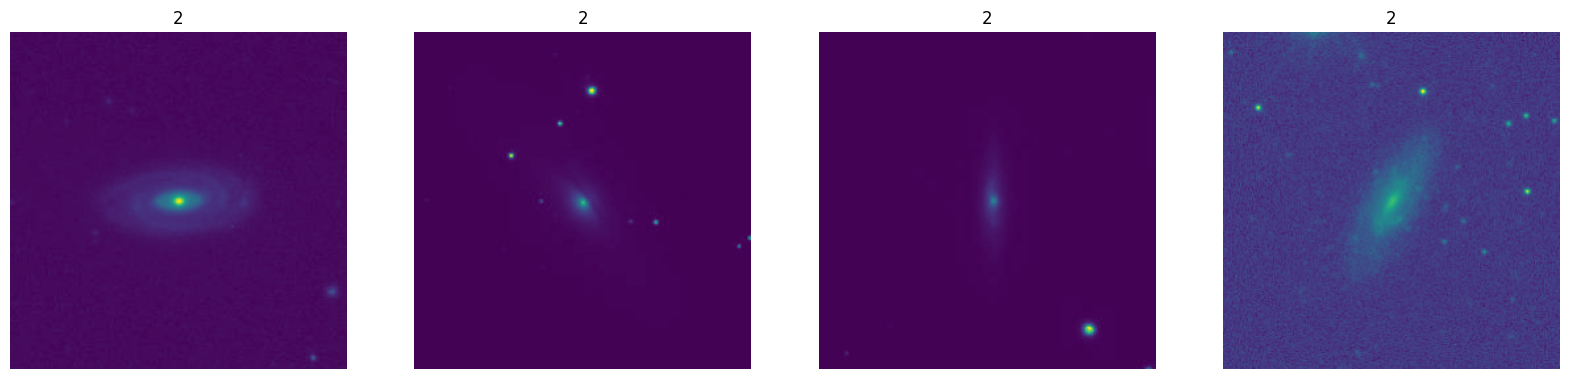

In [70]:
gal_data = gal_data.map(lambda x, y: (x/255, y))  # Normalize images to [0, 1]

scaled_iterator = gal_data.as_numpy_iterator()

batch = scaled_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])
    ax[idx].axis('off')

Check to make sure that images are normalized to be between 0 and 1

In [71]:
batch[0].min()
batch[0].max()

0.9750033

This is where I created created the training, validation, and test size

In [74]:
print(len(gal_data))  # Total number of batches
train_size = int(len(gal_data) * 0.6)
val_size = int(len(gal_data) * 0.3)+1
test_size = int(len(gal_data) * 0.1)

train_size, val_size, test_size
# print(train_size+ val_size + test_size)

145


(87, 44, 14)

In [75]:
train = gal_data.take(train_size) # takes the first 60% of the data for training
val = gal_data.skip(train_size).take(val_size) # takes the next 30% of the data for validation
test = gal_data.skip(train_size + val_size).take(test_size)# # takes the last 10% of the data for testing

The architecute for my CNN and others that I tried

In [76]:
model1 = keras.Sequential()
model1.add(keras.layers.Input(shape=(256, 256, 1)))
model1.add(keras.layers.Conv2D(96, (8, 8), activation='relu'))#convolutional layer with 96 filters and a kernel size of 8x8 with relu activation 
model1.add(keras.layers.Dropout(0.25))#dropout layer to prevent overfitting
model1.add(keras.layers.Activation('relu'))#activation layer to help to find non linear paterns
model1.add(keras.layers.MaxPooling2D((3,3)))#this layer helps reduce the data and captures the important features 
model1.add(keras.layers.Flatten())#fully connected layer
model1.add(keras.layers.Dense(24))#24 neurons connected to the prevous layer
model1.add(keras.layers.Activation('relu'))#activation layer
model1.add(keras.layers.Dropout(0.5))#dropout layer
model1.add(keras.layers.Dense(3, activation='softmax'))#fully connected layer with 3 neurons for the 3 classes
model1.summary()

# model2 = keras.Sequential()
# model2.add(keras.layers.Input(shape=(256, 256, 1)))
# model2.add(keras.layers.Conv2D(96, (8, 8), activation='relu'))
# model2.add(keras.layers.Dropout(0.25))#dropout layer
# model2.add(keras.layers.Activation('relu'))#activation layer
# model2.add(keras.layers.MaxPooling2D((3,3)))
# model2.add(keras.layers.Flatten())
# model2.add(keras.layers.Dense(24))#fully connected layer
# model2.add(keras.layers.Activation('relu'))#activation layer
# model2.add(keras.layers.Dense(3, activation='softmax'))
# model2.summary()

# model3 = keras.Sequential()
# model3.add(keras.layers.Input(shape=(256, 256, 1)))
# model3.add(keras.layers.Conv2D(48, (3, 3), activation='relu'))
# model3.add(keras.layers.Dropout(0.25))#dropout layer
# model3.add(keras.layers.Activation('relu'))#activation layer
# model3.add(keras.layers.Conv2D(24, (3, 3), activation='relu'))
# model3.add(keras.layers.Dropout(0.25))#dropout layer
# model3.add(keras.layers.Activation('relu'))#activation layer
# model3.add(keras.layers.MaxPooling2D((3,3)))
# model3.add(keras.layers.Flatten())
# model3.add(keras.layers.Dense(24))#fully connected layer
# model3.add(keras.layers.Dense(3, activation='softmax'))
# model3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 96)      6240      
                                                                 
 dropout (Dropout)           (None, 249, 249, 96)      0         
                                                                 
 activation (Activation)     (None, 249, 249, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 83, 83, 96)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 661344)            0         
                                                                 
 dense (Dense)               (None, 24)                15872280  
                                                        

In [77]:
model1.compile(optimizer= keras.optimizers.SGD(),
                loss = keras.losses.SparseCategoricalCrossentropy(), #used SparseCategoricalCrossentropy because i didn't one-hot encode the labels
                metrics = [keras.metrics.SparseCategoricalAccuracy()]) 

# model2.compile(optimizer= keras.optimizers.SGD(),
#                 loss = keras.losses.SparseCategoricalCrossentropy(), 
#                 metrics = [keras.metrics.SparseCategoricalAccuracy()])  

# model3.compile(optimizer= keras.optimizers.SGD(),
#                 loss = keras.losses.SparseCategoricalCrossentropy(), 
#                 metrics = [keras.metrics.SparseCategoricalAccuracy()])

In [78]:
history1 = model1.fit(train, epochs=10, validation_data=val) #followed the same process from the neural network activity we did

# history2 = model2.fit(train, epochs=10, validation_data=val) 

# history3 = model3.fit(train, epochs=10, validation_data=val) 

Epoch 1/10
87/87 [==============================] - 129s 1s/step - loss: 0.5169 - sparse_categorical_accuracy: 0.8685 - val_loss: 0.4941 - val_sparse_categorical_accuracy: 0.8750
Epoch 2/10
87/87 [==============================] - 114s 1s/step - loss: 0.4672 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.4886 - val_sparse_categorical_accuracy: 0.8807
Epoch 3/10
87/87 [==============================] - 114s 1s/step - loss: 0.4486 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.4788 - val_sparse_categorical_accuracy: 0.8807
Epoch 4/10
87/87 [==============================] - 112s 1s/step - loss: 0.4248 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.4747 - val_sparse_categorical_accuracy: 0.8764
Epoch 5/10
87/87 [==============================] - 113s 1s/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8908 - val_loss: 0.4741 - val_sparse_categorical_accuracy: 0.8665
Epoch 6/10
87/87 [==============================] - 114s 1s/step - loss: 0.4131 - sparse_categorical_accu

In [79]:
history1.history
# history2.history

{'loss': [0.516933023929596,
  0.46716001629829407,
  0.4486081898212433,
  0.4248066544532776,
  0.4331534802913666,
  0.41313010454177856,
  0.3861449360847473,
  0.4143769145011902,
  0.39823320508003235,
  0.38345301151275635],
 'sparse_categorical_accuracy': [0.868534505367279,
  0.8900862336158752,
  0.8900862336158752,
  0.8929597735404968,
  0.8908045887947083,
  0.892241358757019,
  0.8936781883239746,
  0.892241358757019,
  0.8900862336158752,
  0.897270143032074],
 'val_loss': [0.49405384063720703,
  0.48857545852661133,
  0.47878482937812805,
  0.4746611416339874,
  0.47411367297172546,
  0.47620341181755066,
  0.5127294063568115,
  0.4663121998310089,
  0.4879441261291504,
  0.4987698495388031],
 'val_sparse_categorical_accuracy': [0.875,
  0.8806818127632141,
  0.8806818127632141,
  0.8764204382896423,
  0.8664772510528564,
  0.8764204382896423,
  0.8721590638160706,
  0.8721590638160706,
  0.8678977489471436,
  0.8707386255264282]}

Plotting the accuracy and loss per epoch

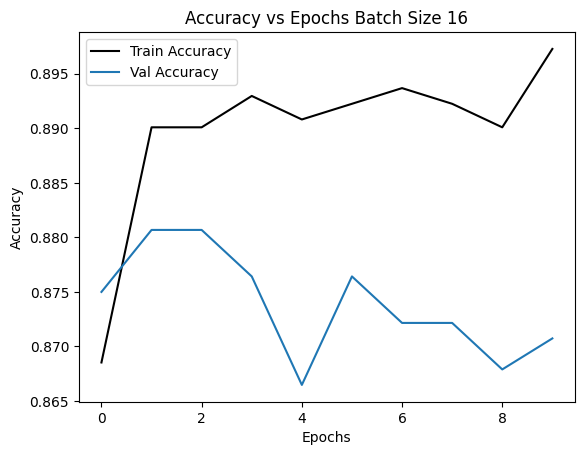

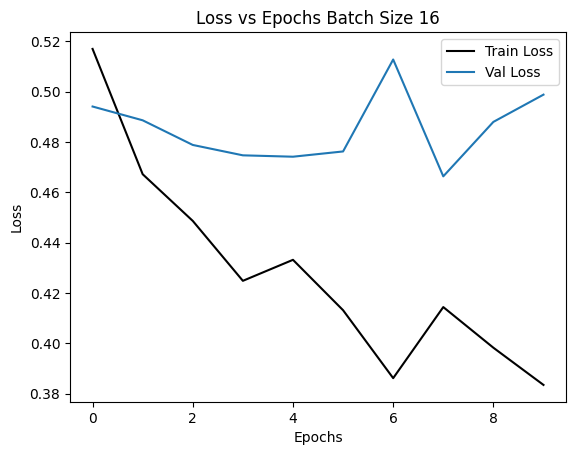

In [85]:
def plot_accuracy_loss(history):
    
    fig = plt.figure()
    plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy', color='black')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs Batch Size 16')
    plt.legend()
    # plt.savefig('accuracy_vs_epochs_batch_size_16.png')
    plt.show()
    
    fig = plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', color='black')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs Batch Size 16')
    plt.legend()
    # plt.savefig('loss_vs_epochs_batch_size_16.png')
    plt.show
    
plot_accuracy_loss(history1)   
# plot_accuracy_loss(history2)

In [86]:
loss_train, acc_train = model1.evaluate(train)
loss_test, acc_test = model1.evaluate(test)

print(f'Train accuracy = {acc_train:.1%}')
print(f'Test accuracy = {acc_test:.1%}')

14/14 [==============================] - 2s 139ms/step - loss: 0.3457 - sparse_categorical_accuracy: 0.9091
Train accuracy = 89.2%
Test accuracy = 90.9%


This is where I plotted my confusion matrix. I was going to show completness and purity of the confusion matrix is my presentation, but I felt like it didn't really matter because everything was classified as a spiral galaxy.

1/1 [==============================] - 0s 146ms/step


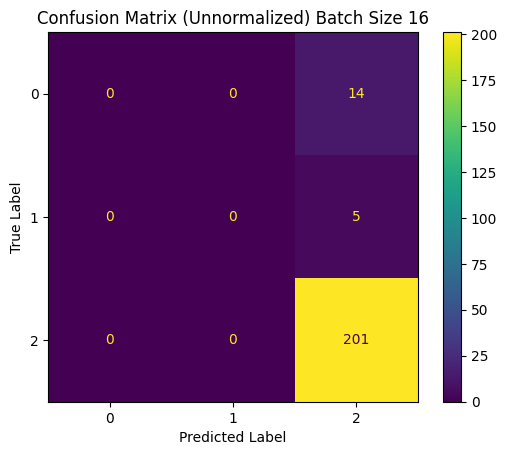

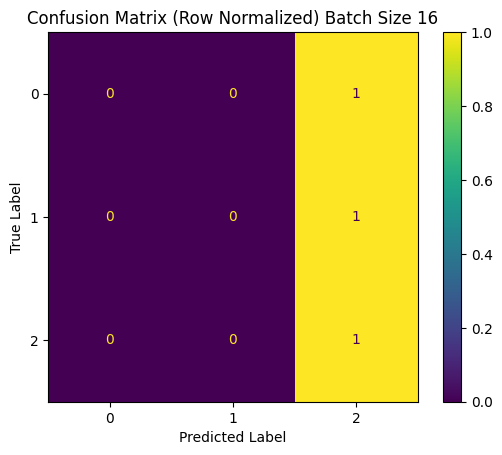

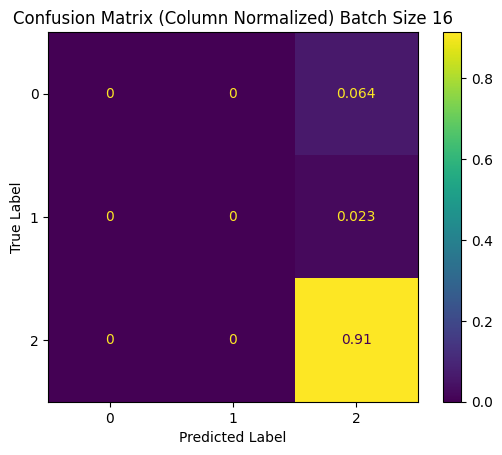

In [ ]:
y_true = []
y_pred_classes = []

y_true2 = []
y_pred_classes2 = []

for batch in test.as_numpy_iterator():
    x, y = batch
    preds = model1.predict(x)
    y_true.extend(y)  # true labels
    y_pred_classes.extend(np.argmax(preds, axis=1))  # predicted class indices


# for batch in test.as_numpy_iterator():
#     x, y = batch
#     preds = model3.predict(x)
#     y_true2.extend(y)  # true labels
#     y_pred_classes2.extend(np.argmax(preds, axis=1))  # predicted class indices

def plot_confusion_matrix(y_true_, y_pred_classes_):
    cm_unnorm = confusion_matrix(y_true_, y_pred_classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm_unnorm, display_labels=range(3)).plot()
    plt.title('Confusion Matrix (Unnormalized) Batch Size 16')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.savefig('cm_unnorm_batch_16.png')
    plt.show()
    
    cm_rownorm = confusion_matrix(y_true, y_pred_classes, normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cm_rownorm, display_labels=range(3)).plot()
    plt.title('Confusion Matrix (Row Normalized) Batch Size 16')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.savefig('cm_rownorm_batch_16.png')
    plt.show()

    cm_colnorm = confusion_matrix(y_true, y_pred_classes, normalize='pred')
    ConfusionMatrixDisplay(confusion_matrix=cm_colnorm, display_labels=range(3)).plot()
    plt.title('Confusion Matrix (Column Normalized) Batch Size 16')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.savefig('cm_colnorm_batch_16.png')
    plt.show()
    
plot_confusion_matrix(y_true, y_pred_classes)   
# plot_confusion_matrix(y_true2, y_pred_classes2)